<a href="https://colab.research.google.com/github/Muskan9114/Customer_churn_prediction/blob/main/customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql.functions import udf, isnan, min, max, sum, count, desc, expr, avg
from pyspark.sql.types import IntegerType, LongType

from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, \
LogisticRegression, GBTClassifier, LogisticRegressionModel, GBTClassificationModel, \
RandomForestClassificationModel
from pyspark.ml.classification import DecisionTreeClassificationModel as DecisionTreeModel


import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd

In [ ]:
# Set Configurations for Spark session
config = pyspark.SparkConf().setAll([('spark.executor.memory', '16g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','16g')])

In [ ]:
# create a Spark session
spark = SparkSession \
    .builder \
    .config(conf=config)\
    .appName('Churn Analysis with Spark') \
    .getOrCreate()

In [ ]:
# Check, if Spark session was setup correctly
spark.sparkContext.getConf().getAll()

[('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.driver.port', '39499'),
 ('spark.driver.host', '6ac9ade3e1bf'),
 ('spark.executor.id', 'driver

In [ ]:
spark

In [ ]:
# Load dataset
df = spark.read.json('mini_sparkify_event_data.json')

In [ ]:
# Show all columns and data types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [ ]:
# Show first 5 rows
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [ ]:
# Show summary statistics
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+-----+--------------------+------+-------+--------------------+-----------------+---------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length|level|            location|method|   page|        registration|        sessionId|     song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+-----+--------------------+------+-------+--------------------+-----------------+---------+------------------+--------------------+--------------------+------------------+
|  count|             18616|     23748|    23009| 23009|             23748|   23009|             18616|23748|               23009| 23748|  23748|               23009|         

In [ ]:
# Show number of rows
df.count()

23748

In [ ]:
# Check for missing values
for column in df.columns:
    nan_missings = df.filter(isnan(df[column])).count()
    null_missings =  df.filter(df[column].isNull()).count()
    empty_missings = df.filter(df[column] == '').count()
    total_missings = nan_missings + null_missings + empty_missings

    # If column has missing values, print details
    if total_missings > 0:
        print(f'{column}: {total_missings} missing values: {nan_missings} Nan, {null_missings} Null, {empty_missings} Empty.')

artist: 5132 missing values: 0 Nan, 5132 Null, 0 Empty.
firstName: 739 missing values: 0 Nan, 739 Null, 0 Empty.
gender: 739 missing values: 0 Nan, 739 Null, 0 Empty.
lastName: 739 missing values: 0 Nan, 739 Null, 0 Empty.
length: 5132 missing values: 0 Nan, 5132 Null, 0 Empty.
location: 739 missing values: 0 Nan, 739 Null, 0 Empty.
registration: 739 missing values: 0 Nan, 739 Null, 0 Empty.
song: 5132 missing values: 0 Nan, 5132 Null, 0 Empty.
userAgent: 739 missing values: 0 Nan, 739 Null, 0 Empty.
userId: 739 missing values: 0 Nan, 0 Null, 739 Empty.


In [ ]:
# Drop rows with missing user id
df = df.where(df.userId != '')
df.count() # Show number of rows after removal of rows with missing ids

23009

In [ ]:
# Drop duplicates
df = df.dropDuplicates()
df.count() # Show number of rows after removal of dupllicates (none!)

23009

In [ ]:
# Preview of all columns
for col in df.columns:
    print(f'{col.title()}')
    print(f'Unique Values: {df.select(col).dropDuplicates().count()}')
    df.select(col).dropDuplicates().sort(col).show(5)

Artist
Unique Values: 5912
+----------+
|    artist|
+----------+
|      NULL|
|       !!!|
|       +44|
|-123 minut|
|  10 Years|
+----------+
only showing top 5 rows

Auth
Unique Values: 2
+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

Firstname
Unique Values: 106
+---------+
|firstName|
+---------+
| Adelaida|
|   Adriel|
|  Ainsley|
|     Alex|
|Alexander|
+---------+
only showing top 5 rows

Gender
Unique Values: 2
+------+
|gender|
+------+
|     F|
|     M|
+------+

Iteminsession
Unique Values: 1095
+-------------+
|itemInSession|
+-------------+
|            0|
|            1|
|            2|
|            3|
|            4|
+-------------+
only showing top 5 rows

Lastname
Unique Values: 99
+--------+
|lastName|
+--------+
| Aguilar|
|Atkinson|
|  Bailey|
|   Baker|
|  Barnes|
+--------+
only showing top 5 rows

Length
Unique Values: 7016
+--------+
|  length|
+--------+
|    NULL|
| 9.01179|
|12.64281|
|  17.162|
|18.05016|
+--------+
only showing to

In [ ]:
# Songs with most interactions
df.select(['artist','song']).groupby(['song','artist']).count().dropna().orderBy('count', ascending=False).show()

In [ ]:
# Inspect Feature 'page'
df.select('page').dropDuplicates().sort('page').show()

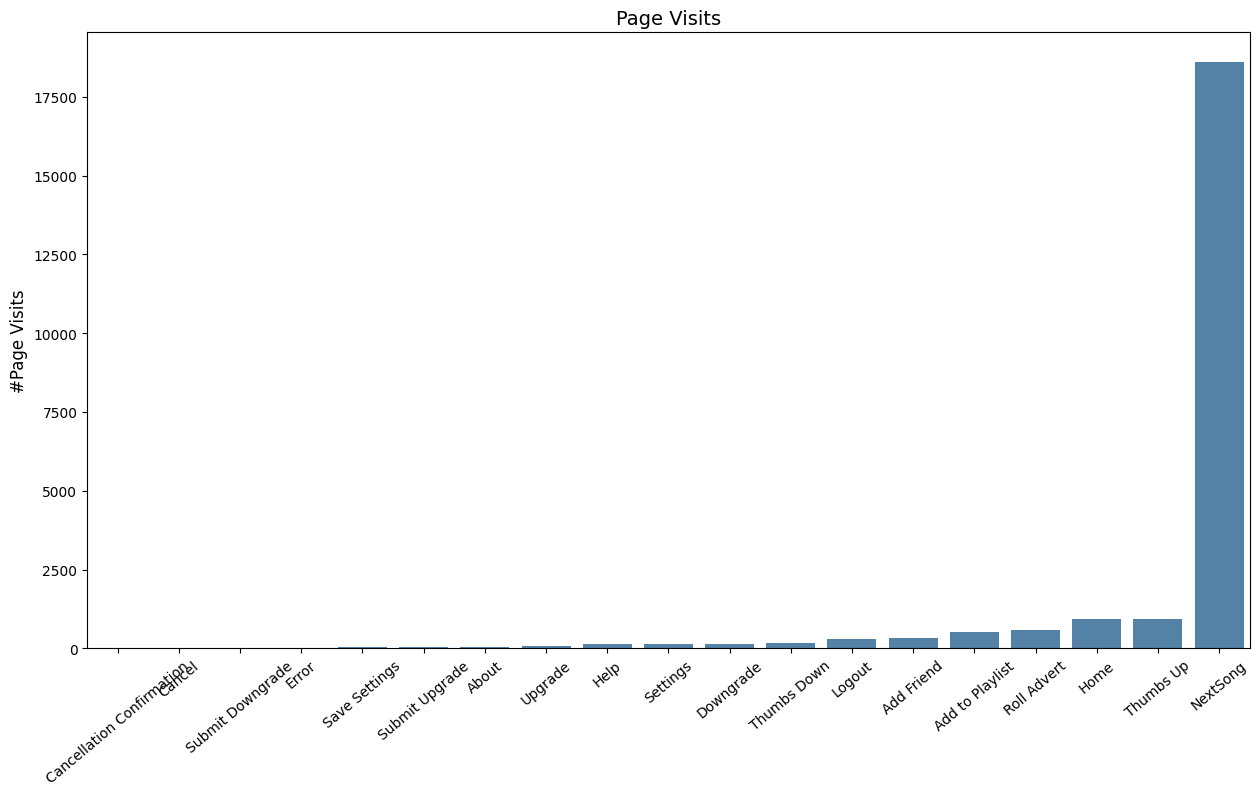

In [ ]:
# Page Visits
page_visits_pd = df.groupby('page').count().toPandas().sort_values('count')

# Plot
plt.figure(figsize=(15,8))
sns.barplot(x='page', y='count', data=page_visits_pd, color='steelblue')
plt.title('Page Visits', fontsize=14)
plt.xticks(rotation=40)
plt.xlabel('', fontsize=12)
plt.ylabel('#Page Visits', fontsize=12)
plt.show()

In [ ]:
# Define "Churn" via user defined function
churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
downgrade_churn = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())

# New dataframe with additional columns 'downgraded' and 'cancelled'
df = df.withColumn('downgraded', downgrade_churn('page')).withColumn('cancelled', churn('page'))

In [ ]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- cancelled: integer (nullable = true)



In [ ]:
df.select(['userId', 'page', 'downgraded', 'cancelled']).head(5)

[Row(userId='78', page='NextSong', downgraded=0, cancelled=0),
 Row(userId='25', page='NextSong', downgraded=0, cancelled=0),
 Row(userId='15', page='NextSong', downgraded=0, cancelled=0),
 Row(userId='51', page='NextSong', downgraded=0, cancelled=0),
 Row(userId='93', page='NextSong', downgraded=0, cancelled=0)]

In [ ]:
df.select(['userId', 'page', 'downgraded', 'cancelled']).where(df.page == 'Submit Downgrade').head(5)

[Row(userId='61', page='Submit Downgrade', downgraded=1, cancelled=0),
 Row(userId='95', page='Submit Downgrade', downgraded=1, cancelled=0),
 Row(userId='13', page='Submit Downgrade', downgraded=1, cancelled=0),
 Row(userId='35', page='Submit Downgrade', downgraded=1, cancelled=0),
 Row(userId='85', page='Submit Downgrade', downgraded=1, cancelled=0)]

In [ ]:
df.select(['userId', 'page', 'downgraded', 'cancelled']).where(df.page == 'Cancellation Confirmation').head(5)

[Row(userId='28', page='Cancellation Confirmation', downgraded=0, cancelled=1),
 Row(userId='103', page='Cancellation Confirmation', downgraded=0, cancelled=1),
 Row(userId='17', page='Cancellation Confirmation', downgraded=0, cancelled=1),
 Row(userId='122', page='Cancellation Confirmation', downgraded=0, cancelled=1),
 Row(userId='32', page='Cancellation Confirmation', downgraded=0, cancelled=1)]

In [ ]:
# Show churn statistics
df.select(['userId','downgraded','cancelled']).groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)','downgraded')\
    .withColumnRenamed('sum(cancelled)','cancelled').describe().show()

+-------+------------------+------------------+-------------------+
|summary|            userId|        downgraded|          cancelled|
+-------+------------------+------------------+-------------------+
|  count|               225|               225|                225|
|   mean|65391.013333333336|              0.28| 0.2311111111111111|
| stddev|105396.47791907164|0.5876709477736183|0.42248321089963276|
|    min|                10|                 0|                  0|
|    max|                99|                 3|                  1|
+-------+------------------+------------------+-------------------+



In [ ]:
print('Number of users who downgraded: ' + str(df.filter(df.downgraded == 1).select('userId').dropDuplicates().count()))
print('Number of users who cancelled: ' + str(df.filter(df.cancelled == 1).select('userId').dropDuplicates().count()))

Number of users who downgraded: 49
Number of users who cancelled: 52


In [ ]:
# Get hour, day, weekday out of timestamp "ts"
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())

# Add columns 'hour', 'day', 'weekday' to dataframe
df_sub = df.withColumn("hour", get_hour(df.ts))
df_sub = df_sub.withColumn("weekday", get_weekday(df.ts))

In [ ]:
df_sub.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- cancelled: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weekday: integer (nullable = true)



In [ ]:
df_sub.select(['userId','ts','hour','weekday']).head(5)

[Row(userId='78', ts=1538373133000, hour=5, weekday=0),
 Row(userId='25', ts=1538384924000, hour=9, weekday=0),
 Row(userId='15', ts=1538394878000, hour=11, weekday=0),
 Row(userId='51', ts=1538405355000, hour=14, weekday=0),
 Row(userId='93', ts=1538411597000, hour=16, weekday=0)]

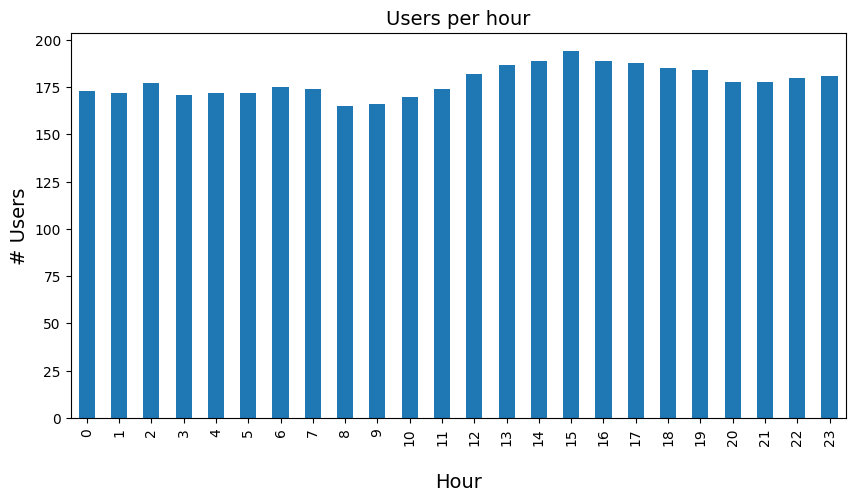

In [ ]:
# User distribution per hour of the day
users_per_hour_pd = df_sub.select(['userId','hour']).dropDuplicates().groupby(['hour']).count().sort('hour').toPandas()

# Plot
ax = users_per_hour_pd.plot(x='hour', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nHour', fontsize=14)
plt.ylabel('# Users', fontsize=14)
plt.title('Users per hour', fontsize=14)
plt.show()

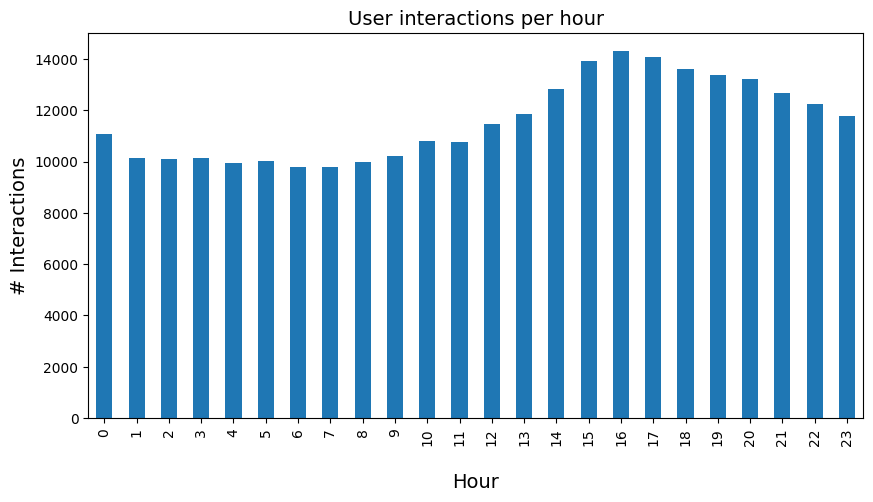

In [ ]:
# User interactions per hour
interacts_per_hour_pd = df_sub.select(['userId','hour']).groupby(['hour']).count().sort('hour').toPandas()

# Plot
ax = interacts_per_hour_pd.plot(x='hour', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nHour', fontsize=14)
plt.ylabel('# Interactions', fontsize=14)
plt.title('User interactions per hour', fontsize=14)
plt.show()

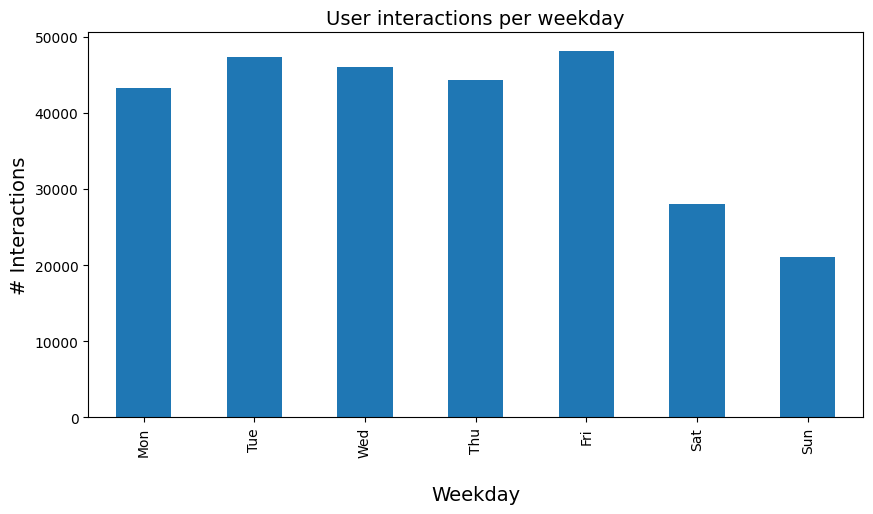

In [ ]:
# User interactions per weekday
interacts_per_weekday_pd = df_sub.select(['userId','weekday']).groupby(['weekday']).count().sort('weekday').toPandas()

# Plot
ax = interacts_per_weekday_pd.plot(x='weekday', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nWeekday', fontsize=14)
plt.ylabel('# Interactions', fontsize=14)
plt.title('User interactions per weekday', fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

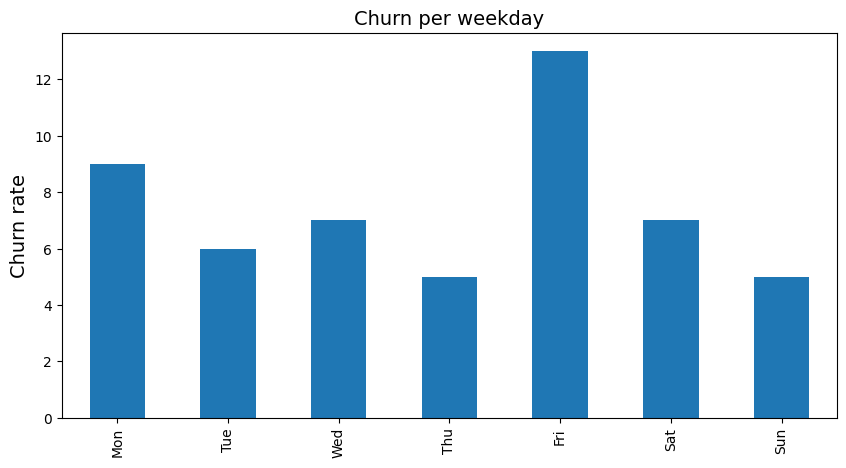

In [ ]:
# Churn per weekday
churn_per_weekday_pd = df_sub.select(['userId','weekday','cancelled']).groupby(['weekday']).sum().sort('weekday').toPandas()

# Plot
ax = churn_per_weekday_pd[['weekday','sum(cancelled)']].plot(x='weekday', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('', fontsize=14)
plt.ylabel('Churn rate', fontsize=14)
plt.title('Churn per weekday', fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

In [ ]:
# Churn per gender
print('Churner per gender')
df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().show()

print('Non-churner per gender')
df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().show()

Churner per gender
+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+

Non-churner per gender
+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



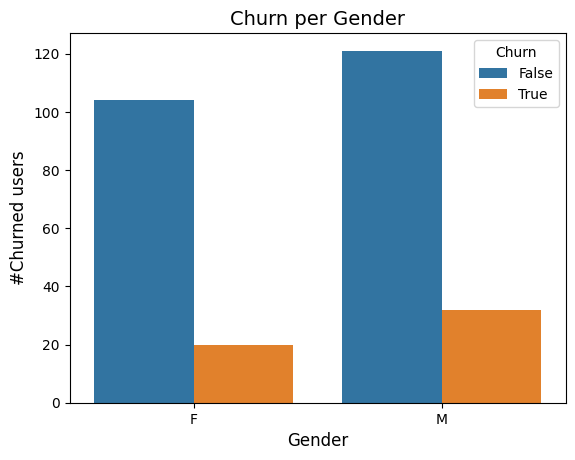

In [ ]:
# Churn per gender plot
churn_gender_pd = df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
churn_gender_pd['Churn'] = True
nonchurn_gender_pd = df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
nonchurn_gender_pd['Churn'] = False
churn_gender = pd.concat([churn_gender_pd,nonchurn_gender_pd], sort=False, ignore_index=True)

# Plot
sns.barplot(x='gender', y='count', hue='Churn', data=churn_gender)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('#Churned users', fontsize=12)
plt.title('Churn per Gender', fontsize=14)
plt.show()

In [ ]:
# Churn per level
print('Churner per level')
df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'level']).drop_duplicates().groupby('level').count().show()

print('Non-churner per level')
df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'level']).drop_duplicates().groupby('level').count().show()

Churner per level
+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+

Non-churner per level
+-----+-----+
|level|count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



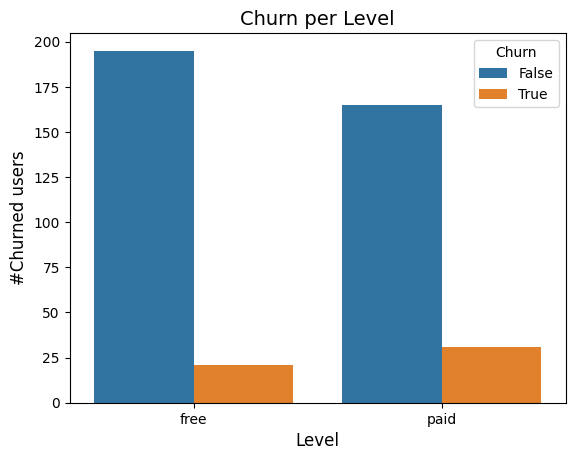

In [ ]:
# Churn per level plot
churn_level_pd = df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'level']).drop_duplicates().groupby('level').count().toPandas()
churn_level_pd['Churn'] = True
nonchurn_level_pd = df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'level']).drop_duplicates().groupby('level').count().toPandas()
nonchurn_level_pd['Churn'] = False
churn_level = pd.concat([churn_level_pd,nonchurn_level_pd], sort=False, ignore_index=True)

# Plot
sns.barplot(x='level', y='count', hue='Churn', data=churn_level)
plt.xlabel('Level', fontsize=12)
plt.ylabel('#Churned users', fontsize=12)
plt.title('Churn per Level', fontsize=14)
plt.show()

In [ ]:
# Churn per device
get_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])
df_devices = df.withColumn('Device', get_device('userAgent'))

print('Churner per device')
df_devices.filter(df.page == 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().show()

print('Non-churner per device')
df_devices.filter(df.page != 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().show()

Churner per device
+---------+-----+
|   Device|count|
+---------+-----+
|      X11|    5|
|   iPhone|    4|
|Macintosh|   19|
|  Windows|   24|
+---------+-----+

Non-churner per device
+----------+-----+
|    Device|count|
+----------+-----+
|      iPad|    3|
|       X11|   12|
|    iPhone|   13|
| Macintosh|   86|
|compatible|    5|
|   Windows|  106|
+----------+-----+



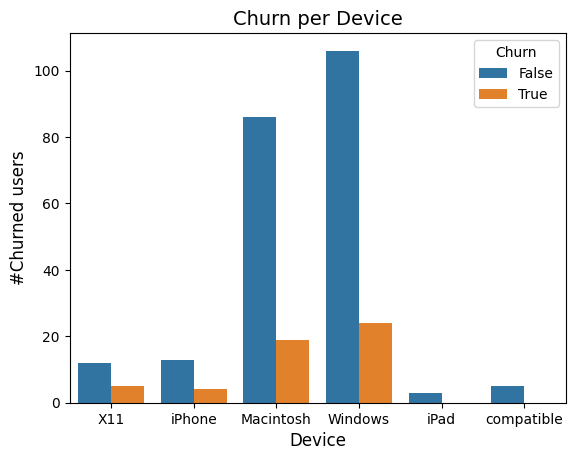

In [ ]:
# Churn per device plot
churn_device_pd = df_devices.filter(df_devices.page == 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().toPandas()
churn_device_pd['Churn'] = True
nonchurn_device_pd = df_devices.filter(df_devices.page != 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().toPandas()
nonchurn_device_pd['Churn'] = False
churn_device = pd.concat([churn_device_pd,nonchurn_device_pd], sort=False, ignore_index=True)

# Plot
sns.barplot(x='Device', y='count', hue='Churn', data=churn_device)
plt.xlabel('Device', fontsize=12)
plt.ylabel('#Churned users', fontsize=12)
plt.title('Churn per Device', fontsize=14)
plt.show()

In [ ]:
# Load small subset for feature engineering
df = spark.read.json('mini_sparkify_event_data.json')

# Drop rows with missing user id
df = df.where(df.userId != '')

In [ ]:
# Create Feature
avg_session_duration = df.select(['userId','sessionId','ts']).groupby(['userId','sessionId']).agg(avg('ts').alias('avg_session_duration'))
avg_session_duration = avg_session_duration.drop('sessionId')
avg_session_duration.show(5)

+------+--------------------+
|userId|avg_session_duration|
+------+--------------------+
|    92|1.538592785972602...|
|    42|1.538685408666666...|
|   101|1.539165263256140...|
|   120|1.539209327272030...|
|   140|1.539424855166666...|
+------+--------------------+
only showing top 5 rows



In [ ]:
# User definded function
get_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# Create feature
churn = df.withColumn('churn', get_churn('page')).select(['userId','churn']).groupby('userId').agg(max('churn').alias('churn'))
# Validation
print('Number of rows: ' + str(churn.count()))
churn.show(5)

Number of rows: 225
+------+-----+
|userId|churn|
+------+-----+
|   125|    1|
|    51|    1|
|   124|    0|
|     7|    0|
|    54|    1|
+------+-----+
only showing top 5 rows



In [ ]:
# User definded function
get_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())

# Create feature
gender = df.withColumn('gender', get_gender('gender')).select(['userId','gender']).groupby('userId').agg(max('gender').alias('gender'))

# Validation
print('Number of rows: ' + str(gender.count()))
gender.show(5)

Number of rows: 225
+------+------+
|userId|gender|
+------+------+
|   125|     1|
|    51|     1|
|   124|     0|
|     7|     1|
|    54|     0|
+------+------+
only showing top 5 rows



In [ ]:
# Create feature
length = df.select(['userId','length']).groupby('userId').agg(sum('length').alias('length'))

# Validation
print('Number of rows: ' + str(length.count()))
length.show(5)

Number of rows: 225
+------+------------------+
|userId|            length|
+------+------------------+
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899992|
|     7| 38034.08710000002|
|    54|  711344.919540001|
+------+------------------+
only showing top 5 rows



In [ ]:
# User definded function
get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

# Create feature
level = df.select(['userId', 'level', 'ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level'])\
        .withColumn('level', get_level('level').cast(IntegerType()))

# Validation
print('Number of rows: ' + str(level.count()))
level.show(5)

Number of rows: 225
+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



In [ ]:
# User definded function
get_location = udf(lambda x: x.split(', ')[1].split('-')[0])
get_location_name = udf(lambda x: "location_"+x.replace(" ", "_").lower())

# Create feature
location = df.withColumn('location', get_location(df['location'])).select(['userId', 'location']).dropDuplicates(['userId'])\
           .groupBy('userId').pivot('location').agg(count('location')).fillna(0)

# Validation
print('Number of rows: ' + str(location.count()))
location.show(5)

Number of rows: 225
+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|userId| AK| AL| AR| AZ| CA| CO| CT| DC| FL| GA| IA| IL| IN| KY| LA| MA| MD| MI| MN| MO| MS| MT| NC| NE| NH| NJ| NV| NY| OH| OK| OR| PA| RI| SC| TN| TX| UT| VA| WA| WI| WV|
+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|    10|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|   100|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|
|100001|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0

In [ ]:
# User definded function
get_page = udf(lambda x: 'page_' + x.replace(' ', '_').lower())
exclude_page = ['Cancel', 'Cancellation Confirmation']

# Create feature
page = df.filter(~df['page'].isin(exclude_page)).withColumn('page', get_page(df['page']))\
                 .groupBy(['userId']).pivot('page').agg(count('page')).fillna(0)

# Validation
print('Number of rows: ' + str(page.count()))
page.show(5)

Number of rows: 225
+------+----------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------+
|userId|page_about|page_add_friend|page_add_to_playlist|page_downgrade|page_error|page_help|page_home|page_logout|page_nextsong|page_roll_advert|page_save_settings|page_settings|page_submit_downgrade|page_submit_upgrade|page_thumbs_down|page_thumbs_up|page_upgrade|
+------+----------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+------------------+-------------+---------------------+-------------------+----------------+--------------+------------+
|200002|         3|              4|                   8|             5|         0|        2|       20|          5|          387|               7|                 0|            3|    

In [ ]:
# Create feature
df_reg_ts = df.select(['userId','registration']).groupby('userId').agg(min('registration').alias('reg_ts'))
df_max_ts = df.select(['userId','ts']).groupby('userId').agg(max('ts').alias('max_ts'))
time_since_reg = df_max_ts.join(df_reg_ts, on=['userId'])

# Calculate Delta
time_since_reg = time_since_reg.withColumn('time_since_reg', expr('max_ts - reg_ts'))
time_since_reg = time_since_reg.drop('max_ts')
time_since_reg = time_since_reg.drop('reg_ts')

# Validation
print('Number of rows: ' + str(time_since_reg.count()))
time_since_reg.show(5)

Number of rows: 225
+------+--------------+
|userId|time_since_reg|
+------+--------------+
|   125|    6161779000|
|    51|    1680985000|
|   124|   11366431000|
|     7|    6288035000|
|    54|    9568946000|
+------+--------------+
only showing top 5 rows



In [ ]:
# Create feature
sessions = df.select(['userId','sessionId']).dropDuplicates().groupby('userId').agg(count('sessionId').alias('sessions'))

# Validation
print('Number of rows: ' + str(sessions.count()))
sessions.show(5)

Number of rows: 225
+------+--------+
|userId|sessions|
+------+--------+
|100010|       7|
|200002|       6|
|   125|       1|
|    51|      10|
|   124|      29|
+------+--------+
only showing top 5 rows



In [ ]:
# Create feature
songs = df.select(['userId','song']).groupby('userId').agg(count('song').alias('songs'))

# Validation
print('Number of rows: ' + str(songs.count()))
songs.show(5)

Number of rows: 225
+------+-----+
|userId|songs|
+------+-----+
|   125|    8|
|    51| 2111|
|   124| 4079|
|     7|  150|
|    54| 2841|
+------+-----+
only showing top 5 rows



In [ ]:
# User definded function
get_agent = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

# Create feature
userAgent = df.withColumn('userAgent', get_agent(df['userAgent'])).select(['userId', 'userAgent']).dropDuplicates(['userId'])\
            .groupBy('userId').pivot('userAgent').agg(count('userAgent')).fillna(0)

# Validation
print('Number of rows: ' + str(userAgent.count()))
userAgent.show(5)

Number of rows: 225
+------+---------+-------+---+----------+----+------+
|userId|Macintosh|Windows|X11|compatible|iPad|iPhone|
+------+---------+-------+---+----------+----+------+
|    10|        1|      0|  0|         0|   0|     0|
|   100|        0|      1|  0|         0|   0|     0|
|100001|        1|      0|  0|         0|   0|     0|
|100002|        0|      1|  0|         0|   0|     0|
|100003|        0|      1|  0|         0|   0|     0|
+------+---------+-------+---+----------+----+------+
only showing top 5 rows



In [ ]:
df = churn.join(avg_session_duration, ['userId'])\
          .join(gender, ['userId'])\
          .join(length, ['userId'])\
          .join(level, ['userId'])\
          .join(location, ['userId'])\
          .join(page, ['userId'])\
          .join(time_since_reg, ['userId'])\
          .join(sessions, ['userId'])\
          .join(songs, ['userId'])\
          .join(userAgent, ['userId'])

In [ ]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- avg_session_duration: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- length: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- AK: long (nullable = true)
 |-- AL: long (nullable = true)
 |-- AR: long (nullable = true)
 |-- AZ: long (nullable = true)
 |-- CA: long (nullable = true)
 |-- CO: long (nullable = true)
 |-- CT: long (nullable = true)
 |-- DC: long (nullable = true)
 |-- FL: long (nullable = true)
 |-- GA: long (nullable = true)
 |-- IA: long (nullable = true)
 |-- IL: long (nullable = true)
 |-- IN: long (nullable = true)
 |-- KY: long (nullable = true)
 |-- LA: long (nullable = true)
 |-- MA: long (nullable = true)
 |-- MD: long (nullable = true)
 |-- MI: long (nullable = true)
 |-- MN: long (nullable = true)
 |-- MO: long (nullable = true)
 |-- MS: long (nullable = true)
 |-- MT: long (nullable = true)
 |-- NC: long (nullable = true)
 |-- NE: long (n

In [ ]:
# Convert df to Pandas df
df_pd = df.toPandas()

In [ ]:
# Correlation matrix
correlation_matrix = df_pd.corr('pearson')

# Too many features to visualize the matrix, so iterate rows and drop highly correlated rows
correlated_columns = []
for column in correlation_matrix.columns:
    correlated = correlation_matrix.drop(column, axis=0).loc[correlation_matrix[column].abs()>=0.5].index.tolist()
    if len(correlated) > 0:
        correlated_columns.append(column)

# Show corelated columns
correlated_columns

['length',
 'MA',
 'page_about',
 'page_add_friend',
 'page_add_to_playlist',
 'page_downgrade',
 'page_error',
 'page_help',
 'page_home',
 'page_logout',
 'page_nextsong',
 'page_roll_advert',
 'page_save_settings',
 'page_settings',
 'page_submit_downgrade',
 'page_submit_upgrade',
 'page_thumbs_down',
 'page_thumbs_up',
 'page_upgrade',
 'sessions',
 'songs',
 'Macintosh',
 'Windows',
 'iPad']

In [ ]:
# Identify features that higly correlate with any other feature
max_corr = 0.85 # Set parameter for maximum permitted pearson correlation coefficient

# Loop over columns
highly_correlated_columns = []
counter = 0
for column in correlated_columns:
    if (column != 'churn') & (correlation_matrix[column].drop(column).max() > max_corr):
        counter += 1
        print(str(counter) + '. ' + str(column))
        highly_correlated_columns.append(column)

print('\n{} highly correlated features (Pearson Correlation Coeffitient larger than {}) to drop.'.format(counter,max_corr))

1. length
2. page_add_friend
3. page_add_to_playlist
4. page_downgrade
5. page_help
6. page_home
7. page_logout
8. page_nextsong
9. page_settings
10. page_thumbs_down
11. page_thumbs_up
12. sessions
13. songs

13 highly correlated features (Pearson Correlation Coeffitient larger than 0.85) to drop.


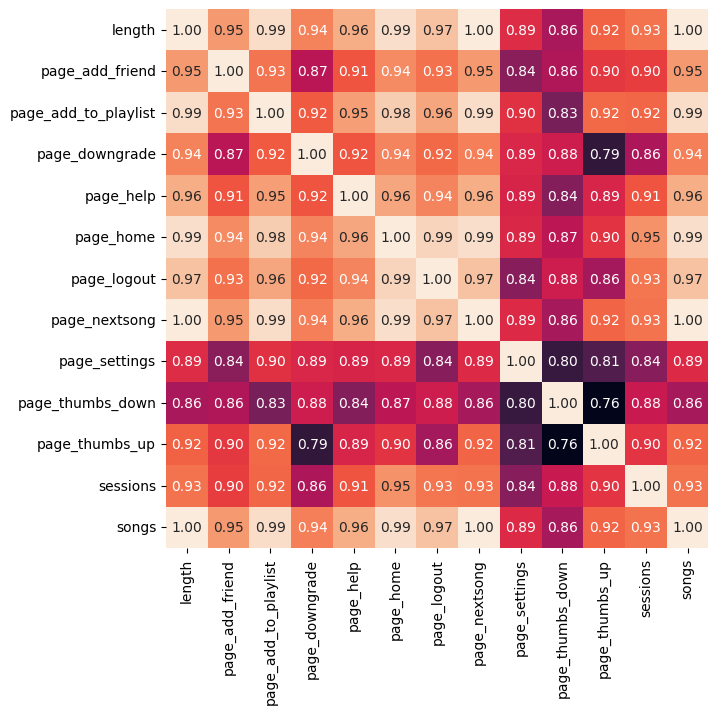

In [ ]:
# Inspect highly correlated features
correlation_matrix_sub = df_pd[highly_correlated_columns].corr('pearson')

# Plot correlation matrix
ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(correlation_matrix_sub, annot = True, fmt = '.2f', cbar=False)
plt.show()

In [ ]:
# Drop features that higly correlate with any other feature
df_pd.drop(highly_correlated_columns, axis=1, inplace=True)

In [ ]:
# Store names of features to keep for further analysis
features_to_keep = list(df_pd.columns)
print(features_to_keep)

['userId', 'churn', 'avg_session_duration', 'gender', 'level', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_upgrade', 'time_since_reg', 'Macintosh', 'Windows', 'X11', 'compatible', 'iPad', 'iPhone']


In [ ]:
# Select features to keep for further analysis from raw data and build a new Spark dataframe
df = df.select(features_to_keep)

# Convert to pandas
df_pd = df.toPandas()

# Print columns
df_pd.columns

Index(['userId', 'churn', 'avg_session_duration', 'gender', 'level', 'AK',
       'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL', 'IN',
       'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH',
       'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT',
       'VA', 'WA', 'WI', 'WV', 'page_about', 'page_error', 'page_roll_advert',
       'page_save_settings', 'page_submit_downgrade', 'page_submit_upgrade',
       'page_upgrade', 'time_since_reg', 'Macintosh', 'Windows', 'X11',
       'compatible', 'iPad', 'iPhone'],
      dtype='object')

In [ ]:
# Check for missing values
missings = df_pd.isnull().sum().sum()
print('Number of missing values: {}'.format(missings))

Number of missing values: 0


In [ ]:
# Distribution of all numerical, non-binary features
num_features = ['avg_session_duration', 'page_about', 'page_error', 'page_roll_advert', 'page_save_settings',
                'page_submit_downgrade', 'page_submit_upgrade', 'page_upgrade', 'time_since_reg']

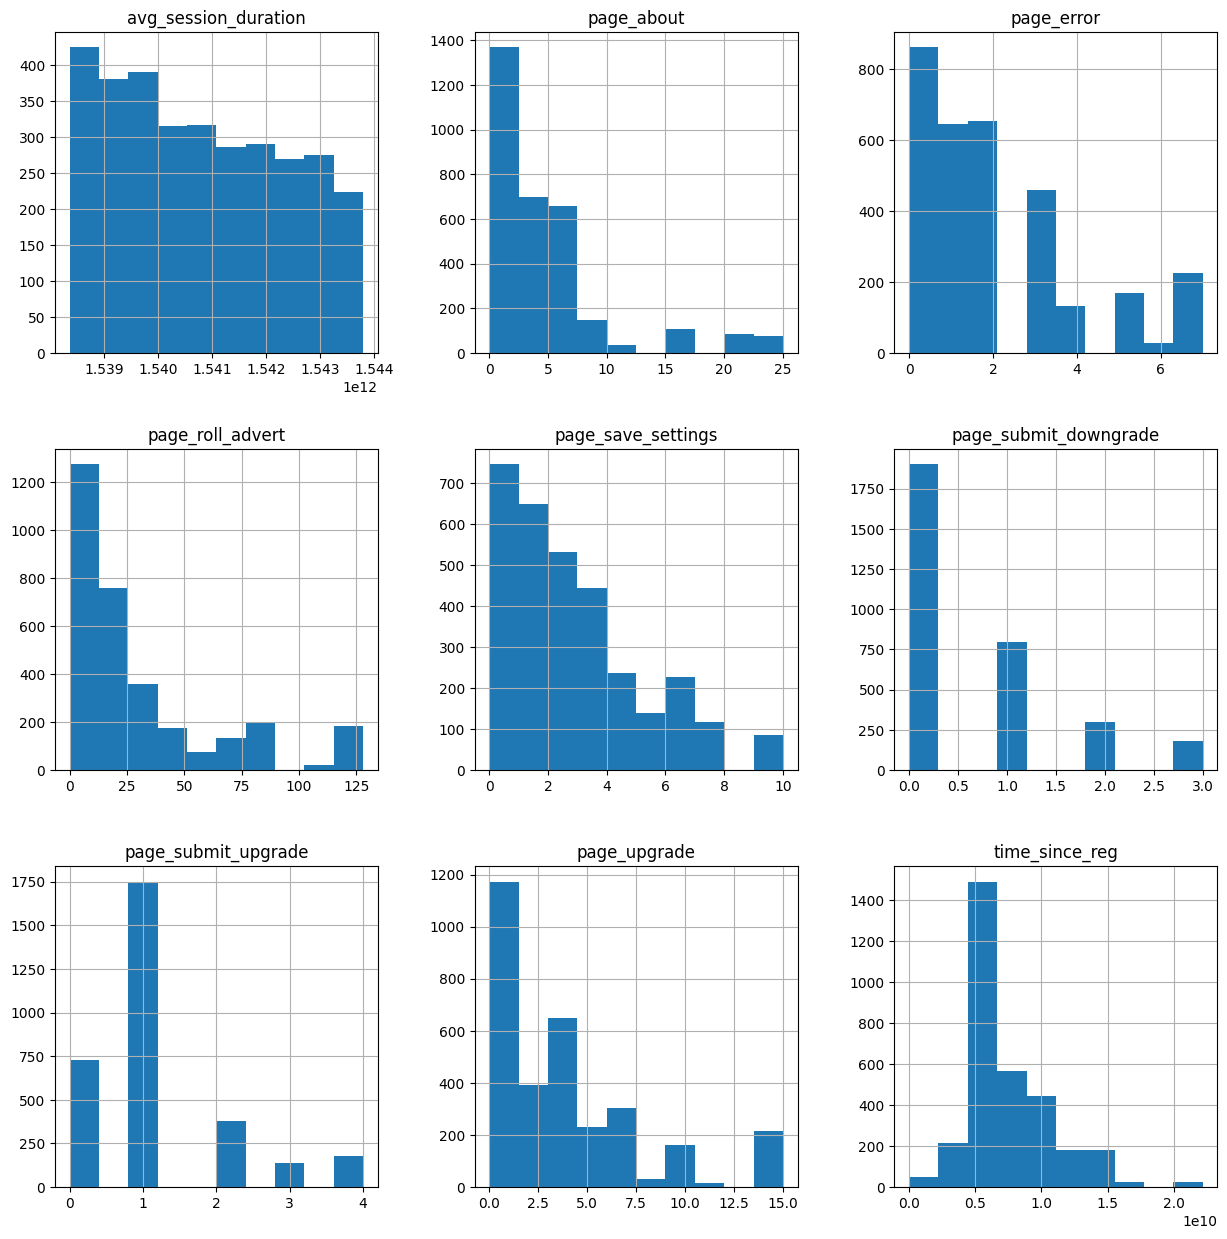

In [ ]:
df_pd[num_features].hist(figsize=(15,15))
plt.show()

In [ ]:
# Vectorize features
assembler = VectorAssembler(inputCols=num_features, outputCol='FeatureVector')
df_assembled = assembler.transform(df)

In [ ]:
# Standardize features
scaler = StandardScaler(inputCol='FeatureVector', outputCol='ScaledNumFeatures', withStd=True)
scalerModel = scaler.fit(df_assembled)
df_scaled = scalerModel.transform(df_assembled)

In [ ]:
df_scaled.head()

Row(userId='125', churn=1, avg_session_duration=1539318297818.182, gender=1, level=0, AK=0, AL=0, AR=0, AZ=0, CA=0, CO=0, CT=0, DC=0, FL=0, GA=0, IA=0, IL=0, IN=0, KY=0, LA=0, MA=0, MD=0, MI=0, MN=0, MO=0, MS=0, MT=0, NC=0, NE=0, NH=0, NJ=0, NV=0, NY=0, OH=0, OK=0, OR=0, PA=0, RI=0, SC=0, TN=0, TX=1, UT=0, VA=0, WA=0, WI=0, WV=0, page_about=0, page_error=0, page_roll_advert=1, page_save_settings=0, page_submit_downgrade=0, page_submit_upgrade=0, page_upgrade=0, time_since_reg=6161779000, Macintosh=1, Windows=0, X11=0, compatible=0, iPad=0, iPhone=0, FeatureVector=SparseVector(9, {0: 1539318297818.182, 3: 1.0, 8: 6161779000.0}), ScaledNumFeatures=SparseVector(9, {0: 991.7829, 3: 0.0298, 8: 1.892}))

In [ ]:
# Train-test-validation split
train_set, rest = df_scaled.drop('userId').randomSplit([0.8, 0.2], seed=42)
validation_set, test_set = rest.randomSplit([0.1,0.1], seed=42)

In [ ]:
def load_data(path):
    '''
    Load a data set that is stored under a given path. Rows with missing ids will be removed.

    INPUT
    - path: Path where the data is stored

    OUTPUT
    - df: Dataframe
    '''

    # Load small subset for feature engineering
    df = spark.read.json(path)

    # Drop rows with missing user id
    df = df.where(df.userId != '')

    return df

In [ ]:
def feature_creation(df):
    '''
    The following Features will be creted at user level:

    1.  avg_session_duration: average session duration [float]
    2.  churn: "1" for a page cancellation confirmation (defined as churn), "0" for absence of churn [binary]
    3.  gender: "1" for male, "0" for female [binary]
    4.  length: total length of songs listened [float]
    5.  level: latest level of a user. "1" for paid, "0" for free [binary]
    6.  location: location of the user [binary]
    7.  page: number visits per page [int]
    8.  time_since_reg: time since registration [int]
    9.  sessions: total number of sessions [int]
    10. songs: total number of songs listend [int]
    11. userAgent: agents used by the user [binary]

    Afterwards, all features are joined, checked for multicollinearity and strongly correlating features will be removed.

    INPUT
    - path: Path where the data is stored

    OUTPUT
    - df: Dataframe
    '''

    # 1.  avg_session_duration
    avg_session_duration = df.select(['userId','sessionId','ts']).groupby(['userId','sessionId'])\
                                     .agg(avg('ts').alias('avg_session_duration'))
    avg_session_duration = avg_session_duration.drop('sessionId')

    # 2.  churn
    get_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    churn = df.withColumn('churn', get_churn('page')).select(['userId','churn'])\
                          .groupby('userId').agg(max('churn').alias('churn'))

    # 3.  gender
    get_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
    gender = df.withColumn('gender', get_gender('gender')).select(['userId','gender'])\
                           .groupby('userId').agg(max('gender').alias('gender'))


    # 4.  length
    length = df.select(['userId','length']).groupby('userId').agg(sum('length').alias('length'))

    # 5.  level
    get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
    level = df.select(['userId', 'level', 'ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level'])\
                      .withColumn('level', get_level('level').cast(IntegerType()))


    # 6.  location
    get_location = udf(lambda x: x.split(', ')[1].split('-')[0])
    get_location_name = udf(lambda x: "location_"+x.replace(" ", "_").lower())
    location = df.withColumn('location', get_location(df['location'])).select(['userId', 'location'])\
                             .dropDuplicates(['userId']).groupBy('userId').pivot('location').agg(count('location')).fillna(0)

    # 7.  page
    get_page = udf(lambda x: 'page_' + x.replace(' ', '_').lower())
    exclude_page = ['Cancel', 'Cancellation Confirmation']
    page = df.filter(~df['page'].isin(exclude_page)).withColumn('page', get_page(df['page']))\
                     .groupBy(['userId']).pivot('page').agg(count('page')).fillna(0)

    # 8.  time_since_reg
    df_reg_ts = df.select(['userId','registration']).groupby('userId').agg(min('registration').alias('reg_ts'))
    df_max_ts = df.select(['userId','ts']).groupby('userId').agg(max('ts').alias('max_ts'))
    time_since_reg = df_max_ts.join(df_reg_ts, on=['userId'])
    time_since_reg = time_since_reg.withColumn('time_since_reg', expr('max_ts - reg_ts'))
    time_since_reg = time_since_reg.drop('max_ts')
    time_since_reg = time_since_reg.drop('reg_ts')

    # 9.  sessions
    sessions = df.select(['userId','sessionId']).dropDuplicates().groupby('userId').agg(count('sessionId').alias('sessions'))

    # 10. songs
    songs = df.select(['userId','song']).groupby('userId').agg(count('song').alias('songs'))

    # 11. userAgent
    get_agent = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])
    userAgent = df.withColumn('userAgent', get_agent(df['userAgent'])).select(['userId', 'userAgent'])\
                              .dropDuplicates(['userId']).groupBy('userId').pivot('userAgent').agg(count('userAgent')).fillna(0)

    # Bringing all together
    df = churn.join(avg_session_duration, ['userId'])\
          .join(gender, ['userId'])\
          .join(length, ['userId'])\
          .join(level, ['userId'])\
          .join(location, ['userId'])\
          .join(page, ['userId'])\
          .join(time_since_reg, ['userId'])\
          .join(sessions, ['userId'])\
          .join(songs, ['userId'])\
          .join(userAgent, ['userId'])

    # Check for multicollinearity
    df_pd = df.toPandas()
    correlation_matrix = df_pd.corr('pearson') # Correlation matrix
    correlated_columns = []
    for column in correlation_matrix.columns: # Iterate rows and drop highly correlated rows
        correlated = correlation_matrix.drop(column, axis=0).loc[correlation_matrix[column].abs()>=0.5].index.tolist()
        if len(correlated) > 0:
            correlated_columns.append(column)


     # Drop features that higly correlate with any other feature
    df_pd.drop(highly_correlated_columns, axis=1, inplace=True)
    features_to_keep = list(df_pd.columns)
    df = df.select(features_to_keep)

    # Check for missing values
    df_pd = df.toPandas()
    missings = df_pd.isnull().sum().sum()
    print('Number of missing values: {}'.format(missings))

    return df

In [ ]:
def feature_scaling(df):
    '''
    Perform feature standardization on a set of given data to ensure the values in a feature follow the
    normal distribution whereby mean of the values is 0 and standard deviation is 1.

    INPUT
    - df: PySpark Dataframe

    OUTPUT
    - scaled_df: PySpark Dataframe with standardized features
    '''

    # Get features without ids and labels
    feature_cols = df.drop('userId', 'churn').columns
    print(str(len(feature_cols)) + ' Features for Scaling:\n')
    print(feature_cols)

    # Vector assembler
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='FeatureVector')

    # PySpark.ML expects the target column to be named as 'labelCol' af data type double
    df = df.withColumn('label', df['churn'].cast('float')).drop('churn')

    # Feature scaler
    #scaler = StandardScaler(inputCol='FeatureVector', outputCol='ScaledFeatures', withStd=True)
    scaler = MinMaxScaler(inputCol='FeatureVector', outputCol='ScaledFeatures')

    # Perform assembling and standardizing of features
    df = assembler.transform(df)
    scalerModel = scaler.fit(df)
    scaled_df = scalerModel.transform(df)

    # Visulize example row
    print('\nExample row of scaled features:\n')
    print(scaled_df.head(1))

    # Just take scaled feature vector and labels
    scaled_df = scaled_df.select('ScaledFeatures', 'label')
    print('\nReduced to scaled feature vector and labels:\n')
    print(scaled_df.printSchema())
    print(scaled_df.head(1))

    return scaled_df

In [ ]:
# Testing of feature scaling function
test_df = feature_scaling(df)

58 Features for Scaling:

['avg_session_duration', 'gender', 'level', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_upgrade', 'time_since_reg', 'Macintosh', 'Windows', 'X11', 'compatible', 'iPad', 'iPhone']

Example row of scaled features:

[Row(userId='125', avg_session_duration=1539318297818.182, gender=1, level=0, AK=0, AL=0, AR=0, AZ=0, CA=0, CO=0, CT=0, DC=0, FL=0, GA=0, IA=0, IL=0, IN=0, KY=0, LA=0, MA=0, MD=0, MI=0, MN=0, MO=0, MS=0, MT=0, NC=0, NE=0, NH=0, NJ=0, NV=0, NY=0, OH=0, OK=0, OR=0, PA=0, RI=0, SC=0, TN=0, TX=1, UT=0, VA=0, WA=0, WI=0, WV=0, page_about=0, page_error=0, page_roll_advert=1, page_save_settings=0, page_submit_downgrade=0, page_submit_upgr

In [ ]:
def train_test_split(scaled_df):
    '''
    Split the data into training set and test set.

    INPUT
    - df: Scaled PySpark Dataframe

    OUTPUT
    - train_set: training set
    - test_set: test set
    '''

    # Train-test-validation split
    train_set, test_set = scaled_df.drop('userId').randomSplit([0.8, 0.2], seed=42)

    return train_set, test_set

In [ ]:
# Testing of train-test split function
train_set, test_set = train_test_split(test_df)
print('Visualization of one train set row:\n')
print(train_set.head(1))

print('\n--------------------------------')
print('Size of whole data set: ' + str(test_df.count()))
print('--------------------------------')
print('Size of train set: ' + str(train_set.count()))
print('Size of test set: ' + str(test_set.count()))
print('--------------------------------')

Visualization of one train set row:

[Row(ScaledFeatures=SparseVector(58, {0: 0.0565, 1: 1.0, 2: 1.0, 3: 1.0, 44: 0.12, 45: 0.2857, 46: 0.0859, 47: 0.1, 49: 0.25, 50: 0.0667, 51: 0.3711, 52: 1.0}), label=0.0)]

--------------------------------
Size of whole data set: 3176
--------------------------------
Size of train set: 2592
Size of test set: 584
--------------------------------


In [ ]:
def cross_validation(classifier, parameter_grid):
    '''
    Performs Cross validation
    Cross validation is a technique for estimating the performance of a predictive model

    INPUT
    - classifier: untrained classifier
    - parameter_grid: a grid of parameters

    OUTPUT
    - crossval: cross validator
    '''

    crossval = CrossValidator(estimator = classifier,
                              estimatorParamMaps = parameter_grid,
                              evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                              numFolds = 3)

    return crossval

In [ ]:
def train_model(classifier, train_set, parameter_grid):
    '''
    Training of classification model

    INPUT
    - classifier: untrained classifier
    - train_set: training data
    - parameter_grid: a grid of parameters

    OUTPUT
    - model: trained classifier
    '''

    # Cross validation
    crossval = cross_validation(classifier, parameter_grid)

    # Train model
    model = crossval.fit(train_set)

    return model

In [ ]:
def evaluate_model(classifier, data):
    '''
    Evaluation of trained classification model

    INPUT
    - classifier: trained classifier
    - data: evaluation data

    OUTPUT
    - metrics : Disctionary of evaluation metrics
    '''

    # Predict
    predictions = classifier.transform(data)

    # Evaluator
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label')

    # Calculate metrics
    metrics = {}
    metrics['precision'] = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedPrecision'})
    metrics['recall'] = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedRecall'})
    metrics['f1'] = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})
    metrics['accuracy'] = evaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'})
    metrics['confusion_matrix'] = predictions.groupby('label').pivot('prediction').count()

    return metrics

In [ ]:
def ml_pipeline(model, path):
    '''
    Machine Learning pipeline that brings all steps together:
    1. Load data
    2. Feature creation
    3. Feature Scaling
    4. Train-Test Split
    5. Build model
    6. Cross validation
    7. Model training
    8. Model evaluation

    INPUT
    - model: classification model to build
    - train_set: training data
    - test_set: test data

    OUTPUT
    - trained_classifier: trained model
    '''
    print('\nModel: ' + model + '\n')

    print('----------------------------')
    print('1. Load Data')
    print('----------------------------')

    df = load_data(path)

    print('----------------------------')
    print('2. Feature Creation')
    print('----------------------------')

    df = feature_creation(df)

    print('----------------------------')
    print('3. Feature Scaling')
    print('----------------------------')

    scaled_df = feature_scaling(df)

    print('----------------------------')
    print('4. Train-Test Split')
    print('----------------------------')

    train_set, test_set = train_test_split(scaled_df)

    print('----------------------------')
    print('5. Build model')
    print('----------------------------')

    if model == 'Decision Tree':
        classifier = DecisionTreeClassifier(labelCol='label', featuresCol='ScaledFeatures')
        file_name = 'cv_dtree_cf.model'
    if model == 'Random Forest':
        classifier = RandomForestClassifier(labelCol='label', featuresCol='ScaledFeatures')
        file_name = 'cv_randomforest_cf.model'
    if model == 'Logistic Regression':
        classifier = LogisticRegression(labelCol='label', featuresCol='ScaledFeatures')
        file_name = 'cv_logreg_cf.model'
    if model == 'Gradient Boosting':
        classifier = GBTClassifier(labelCol='label', featuresCol='ScaledFeatures')
        file_name = 'cv_gradientboo_cf.model'

    print('----------------------------')
    print('6. & 7. Cross Val. & Training')
    print('----------------------------')

    parameter_grid = ParamGridBuilder().build()
    trained_classifier = train_model(classifier, train_set, parameter_grid)

    # Get best model
    bestModel = trained_classifier.bestModel

    # Save trained model
    bestModel.write().overwrite().save(file_name)

    print('----------------------------')
    print('8. Model Evaluation')
    print('----------------------------')

    metrics = evaluate_model(trained_classifier, test_set)
    print(metrics)

    return trained_classifier

In [ ]:
# 1. Model: Random Forest Classifier
cv_randomforest_cf = ml_pipeline('Random Forest', 'mini_sparkify_event_data.json')


Model: Random Forest

----------------------------
1. Load Data
----------------------------
----------------------------
2. Feature Creation
----------------------------
Number of missing values: 0
----------------------------
3. Feature Scaling
----------------------------
58 Features for Scaling:

['avg_session_duration', 'gender', 'level', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_upgrade', 'time_since_reg', 'Macintosh', 'Windows', 'X11', 'compatible', 'iPad', 'iPhone']

Example row of scaled features:

[Row(userId='125', avg_session_duration=1539318297818.182, gender=1, level=0, AK=0, AL=0, AR=0, AZ=0, CA=0, CO=0, CT=0, DC=0, FL=0, GA=0, IA=0, IL=0, IN=0, KY

In [ ]:
# 2. Model: Decision Tree Classifier
cv_dtree_cf = ml_pipeline('Decision Tree', 'mini_sparkify_event_data.json')


Model: Decision Tree

----------------------------
1. Load Data
----------------------------
----------------------------
2. Feature Creation
----------------------------
Number of missing values: 0
----------------------------
3. Feature Scaling
----------------------------
58 Features for Scaling:

['avg_session_duration', 'gender', 'level', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_upgrade', 'time_since_reg', 'Macintosh', 'Windows', 'X11', 'compatible', 'iPad', 'iPhone']

Example row of scaled features:

[Row(userId='125', avg_session_duration=1539318297818.182, gender=1, level=0, AK=0, AL=0, AR=0, AZ=0, CA=0, CO=0, CT=0, DC=0, FL=0, GA=0, IA=0, IL=0, IN=0, KY

In [ ]:
# 3. Model: Logistic Regression Classifier
cv_logreg_cf = ml_pipeline('Logistic Regression', 'mini_sparkify_event_data.json')


Model: Logistic Regression

----------------------------
1. Load Data
----------------------------
----------------------------
2. Feature Creation
----------------------------
Number of missing values: 0
----------------------------
3. Feature Scaling
----------------------------
58 Features for Scaling:

['avg_session_duration', 'gender', 'level', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_upgrade', 'time_since_reg', 'Macintosh', 'Windows', 'X11', 'compatible', 'iPad', 'iPhone']

Example row of scaled features:

[Row(userId='125', avg_session_duration=1539318297818.182, gender=1, level=0, AK=0, AL=0, AR=0, AZ=0, CA=0, CO=0, CT=0, DC=0, FL=0, GA=0, IA=0, IL=0, IN

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 56318)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
Traceback (most recent call last):
  File "/usr/lib/python3.11/socketserver.py", line 317, in _h

Py4JError: An error occurred while calling o9737.fit

In [ ]:
# 4. Model: Gradient Boosting Classifier
cv_gradientboo_cf = ml_pipeline('Gradient Boosting', 'mini_sparkify_event_data.json')